In [2]:
from kitti_detection import config
from kitti_detection.dataset import DataSample, class_names, load_train_val_test_dataset
from kitti_detection.utils import display_samples_h
from kitti_detection import box_utils

import torch
import torchvision
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.tv_tensors import BoundingBoxes

from scipy.optimize import linear_sum_assignment

In [3]:
IMG_WIDTH, IMG_HEIGHT = 370, 370

box_normalize_tensor = torch.tensor([1 / IMG_WIDTH, 1 / IMG_HEIGHT, 1 / IMG_WIDTH, 1 / IMG_HEIGHT])
box_inv_normalize_tensor = torch.tensor([IMG_WIDTH, IMG_HEIGHT, IMG_WIDTH, IMG_HEIGHT])

In [4]:
class NormalizeBoxes(v2.Transform):
    def forward(self, img, target):
        target['boxes'] *= box_normalize_tensor
        return img, target

In [5]:
base_transform = v2.Compose([
    v2.RandomCrop(size=(370, 370)),
    v2.SanitizeBoundingBoxes(),
    v2.ConvertBoundingBoxFormat(format='cxcywh'),
])

In [6]:
preprocess_img = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
preprocess_label = NormalizeBoxes()

In [8]:
transforms = v2.Compose([
    base_transform,
    preprocess_img,
    preprocess_label,
])

In [9]:
train_dataset, valid_dataset, test_dataset = load_train_val_test_dataset()

train_dataset.transform = transforms
valid_dataset.transform = transforms

In [10]:
classes = class_names[:-1]
n_classes = len(classes)

class_counts = {
    'Car': 8297, 
    'Van': 881, 
    'Truck': 343, 
    'Pedestrian': 1034, 
    'Person_sitting': 44, 
    'Cyclist': 374, 
    'Tram': 140, 
    'Misc': 251, 
    'DontCare': 0
}
class_weights = [ 1 / class_counts[c] for c in classes]

print(class_weights)


[0.0001205254911413764, 0.0011350737797956867, 0.0029154518950437317, 0.0009671179883945841, 0.022727272727272728, 0.00267379679144385, 0.007142857142857143, 0.00398406374501992]


In [11]:
def get_1d_pos_encoding(l, dim):
    return torch.cat([
        torch.stack([
            torch.linspace(0, 10000**(2*i/dim), steps=l).sin(),
            torch.linspace(0, 10000**(2*i/dim), steps=l).cos()
        ], dim=1)
        for i in range(dim // 2)
    ], dim=1)

def create_pos_encoding(h, w, dim):
    col_embed = get_1d_pos_encoding(w, dim // 2).repeat(h, 1, 1)
    row_embed = get_1d_pos_encoding(h, dim // 2).unsqueeze(1).repeat(1, w, 1)
    
    return torch.cat((col_embed, row_embed), dim=-1)

In [12]:
class DETR(nn.Module):

    def __init__(self, dim_embed=256, n_queries=20):
        super().__init__()
        self.backbone = self._backbone()
        self.conv = nn.Conv2d(512, dim_embed, kernel_size=1)

        self.register_buffer('pos_embedding', create_pos_encoding(12, 12, dim_embed)) # (12, 12, 256)
        # self.register_buffer('query_pos_embedding', get_1d_pos_encoding(n_queries, dim_embed))
        self.register_buffer('query_pos_embedding', torch.zeros((n_queries, dim_embed)))

        self.transformer = nn.Transformer(dim_embed, nhead=8, num_encoder_layers=8, num_decoder_layers=8, batch_first=True)

        self.linear_class = nn.Linear(dim_embed, n_classes + 1)
        self.linear_bbox = nn.Linear(dim_embed, 4)

    def _backbone(self) -> nn.Module:
        backbone = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        del backbone.fc
        del backbone.avgpool

        for module in backbone.modules():
            if isinstance(module, nn.BatchNorm2d):
                module.eval()
                for param in module.parameters():
                    param.requires_grad = False

        def _forward(bb: torchvision.models.ResNet, x):
            x = bb.conv1(x)
            x = bb.bn1(x)
            x = bb.relu(x)
            x = bb.maxpool(x)

            x = bb.layer1(x)
            x = bb.layer2(x)
            x = bb.layer3(x)
            x = bb.layer4(x)
            return x

        backbone.forward = lambda x: _forward(backbone, x)
        return backbone

    def forward(self, input):
        batch_size = input.shape[0]

        x = self.backbone(input) # (4, 512, 12, 12)
        x = self.conv(x) # (4, 256, 12, 12)

        x = x.permute(0, 2, 3, 1) # (4, 12, 12, 256)
        x = x #+ 0.1 * self.pos_embedding
        x = x.flatten(1, 2) # (4, 144, 256)

        q = self.query_pos_embedding.repeat(batch_size, 1, 1)
        q = self.transformer(x, q)

        return self.linear_class(q)


In [13]:
def _collate(samples):
    imgs = tuple( img for img, _ in samples )
    targets = tuple( target for _, target in samples )
    return torch.stack(imgs), tuple(targets)

In [92]:
class HungarianLoss(nn.Module):
    def __init__(self, num_classes, class_weights, empty_weight, loss_weight_dict):
        super().__init__()
        self.num_classes = num_classes
        class_weights = torch.tensor(class_weights)
        class_weights = class_weights / class_weights.sum()
        class_weights = torch.cat([class_weights, torch.tensor([empty_weight])])
        self.loss_weight_dict = loss_weight_dict
        self.register_buffer('class_weights', class_weights)

    def get_loss_labels(self, outputs, targets):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        src_logits = outputs['pred_logits']

        target_classes = [8] * 20
        target_classes[0] = 1
        target_classes[1] = 2
        target_classes[2] = 3
        target_classes = torch.tensor([target_classes], device='cuda:0')
        print(target_classes)

        loss = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.class_weights.to(src_logits.device))
        return loss

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def forward(self, outputs, targets):
        outputs = {
            'pred_logits': outputs,
            'pred_boxes': torch.zeros(size=(outputs.shape[0], outputs.shape[1], 4), device='cuda:0')
        }

        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=outputs['pred_logits'].device)

        loss_labels = self.get_loss_labels(outputs, targets)
        loss_bbox = loss_giou = 0

        losses = {
            'loss_labels': loss_labels,
            'loss_bbox': loss_bbox,
            'loss_giou': loss_giou,
        }

        loss_sum = loss_labels
        return loss_sum, losses


In [93]:
BATCH_SIZE = 1

In [94]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=_collate, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=_collate, num_workers=4)

In [95]:
def targets_to_device(targets, device):
    return tuple({k: v.to(device) for k, v in target.items()} for target in targets)

In [96]:
def train_model(model: nn.Module,
                device: str,
                train_loader: DataLoader,
                valid_loader: DataLoader,
                batch_size: int,
                loss_fn: nn.Module,
                optimizer: optim.Optimizer,
                epochs: int,
                scheduler: optim.lr_scheduler.LRScheduler = None,
                early_stopping_patience: int = None
                ):

    model = model.to(device)
    num_train_samples = len(train_loader.dataset)
    best_loss = float('inf')
    patience = early_stopping_patience

    for epoch in range(epochs):
        # train
        num_batches = len(train_loader)
        model = model.train()
        train_loss = 0.0

        for batch, (X, y) in enumerate(train_loader):
            #print(f'[{epoch + 1:>2}/{epochs}]:', end='\r')
            X = X.to(device)
            y = targets_to_device(y, device)
            
            pred = model(X)
            #print(pred['pred_logits'][0][0])
            loss, loss_dict = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss = loss.item()
            train_loss += loss
            
            current = batch * batch_size + len(X)
            print(f'[{epoch + 1:>2}/{epochs}]: train_loss={loss:>5f} {loss_dict=} [{current:>5d}/{num_train_samples:>5d}]')
            if batch >= 4:
                break
        train_loss /= num_batches

        if scheduler:
            scheduler.step()

        # validate
        model = model.eval()
        n_samples = 0
        num_batches = len(valid_loader)
        val_loss = 0

        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                y = targets_to_device(y, device)
                pred = model(X)
                loss, _  = loss_fn(pred, y)
                val_loss += loss.item()
                n_samples += len(X)

        val_loss /= num_batches
        print(f'[{epoch + 1:>2}/{epochs}]: {train_loss=:5f} {val_loss=:5.5f}')
        
        patience -= 1

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), config.CURRENT_MODEL_PATH)
            patience = early_stopping_patience
        if patience == 0:
            break

    #model.load_state_dict(torch.load(config.CURRENT_MODEL_PATH))
    print(f'\nbest model:')
    print(f'\tval_loss={best_loss:2f}')


In [97]:
model = DETR()

In [98]:
loss_weight_dict = {'loss_labels': 0.33, 'loss_bbox': 0.33, 'loss_giou': 0.33}
loss_fn = HungarianLoss(num_classes=len(classes), class_weights=class_weights, empty_weight=0.0005, loss_weight_dict=loss_weight_dict)

train_model(
    model,
    device='cuda:0',
    train_loader=train_loader,
    valid_loader=valid_loader,
    batch_size=BATCH_SIZE,
    loss_fn=loss_fn,
    optimizer=optim.Adam(model.parameters(), lr=0.00001),
    epochs=1,
    early_stopping_patience=10,
)

tensor([[1, 2, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]],
       device='cuda:0')
[ 1/1]: train_loss=2.899777 loss_dict={'loss_labels': tensor(2.8998, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': 0, 'loss_giou': 0} [    1/ 5237]
tensor([[1, 2, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]],
       device='cuda:0')
[ 1/1]: train_loss=2.281908 loss_dict={'loss_labels': tensor(2.2819, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': 0, 'loss_giou': 0} [    2/ 5237]
tensor([[1, 2, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]],
       device='cuda:0')
[ 1/1]: train_loss=1.581861 loss_dict={'loss_labels': tensor(1.5819, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': 0, 'loss_giou': 0} [    3/ 5237]
tensor([[1, 2, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]],
       device='cuda:0')
[ 1/1]: train_loss=1.387586 loss_dict={'loss_labels': tensor(1.3876, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_bbox': 0

In [99]:
print(loss_fn.class_weights)

tensor([2.8926e-03, 2.7242e-02, 6.9972e-02, 2.3211e-02, 5.4546e-01, 6.4172e-02,
        1.7143e-01, 9.5619e-02, 5.0000e-04])


In [100]:
#model.load_state_dict(torch.load(config.CURRENT_MODEL_PATH))

In [101]:
test_transform = v2.Compose([
    v2.CenterCrop(size=(370, 370)),
    v2.SanitizeBoundingBoxes(),
    v2.ConvertBoundingBoxFormat(format='cxcywh'),
])
test_dataset.transform = test_transform

In [102]:
samples = [ train_dataset[i] for i in range(10, 14) ]

In [103]:
def postprocess_preds(preds):
    print(preds)
    #pred_label_dist = torch.softmax(preds['pred_logits'], dim=-1)
    #pred_confidences, pred_labels = torch.max(pred_label_dist, dim=-1)
    #print(pred_label_dist)
    #print(pred_confidences)
    #print(preds['pred_boxes'])

In [104]:
model = model.to('cpu')

with torch.no_grad():
    X = torch.stack([img for img, _ in samples])

    preds = model(X)
    preds = postprocess_preds(preds)


tensor([[[-0.3668,  0.7493,  1.7639,  0.1117, -1.0309, -0.7368, -0.5433,
          -0.4575, -0.3275],
         [-0.3668,  0.7493,  1.7639,  0.1117, -1.0309, -0.7368, -0.5433,
          -0.4575, -0.3275],
         [-0.3668,  0.7493,  1.7639,  0.1117, -1.0309, -0.7368, -0.5433,
          -0.4575, -0.3275],
         [-0.3668,  0.7493,  1.7639,  0.1117, -1.0309, -0.7368, -0.5433,
          -0.4575, -0.3275],
         [-0.3668,  0.7493,  1.7639,  0.1117, -1.0309, -0.7368, -0.5433,
          -0.4575, -0.3275],
         [-0.3668,  0.7493,  1.7639,  0.1117, -1.0309, -0.7368, -0.5433,
          -0.4575, -0.3275],
         [-0.3668,  0.7493,  1.7639,  0.1117, -1.0309, -0.7368, -0.5433,
          -0.4575, -0.3275],
         [-0.3668,  0.7493,  1.7639,  0.1117, -1.0309, -0.7368, -0.5433,
          -0.4575, -0.3275],
         [-0.3668,  0.7493,  1.7639,  0.1117, -1.0309, -0.7368, -0.5433,
          -0.4575, -0.3275],
         [-0.3668,  0.7493,  1.7639,  0.1117, -1.0309, -0.7368, -0.5433,
         

ValueError: For pure tensor inputs, `old_format` has to be passed.

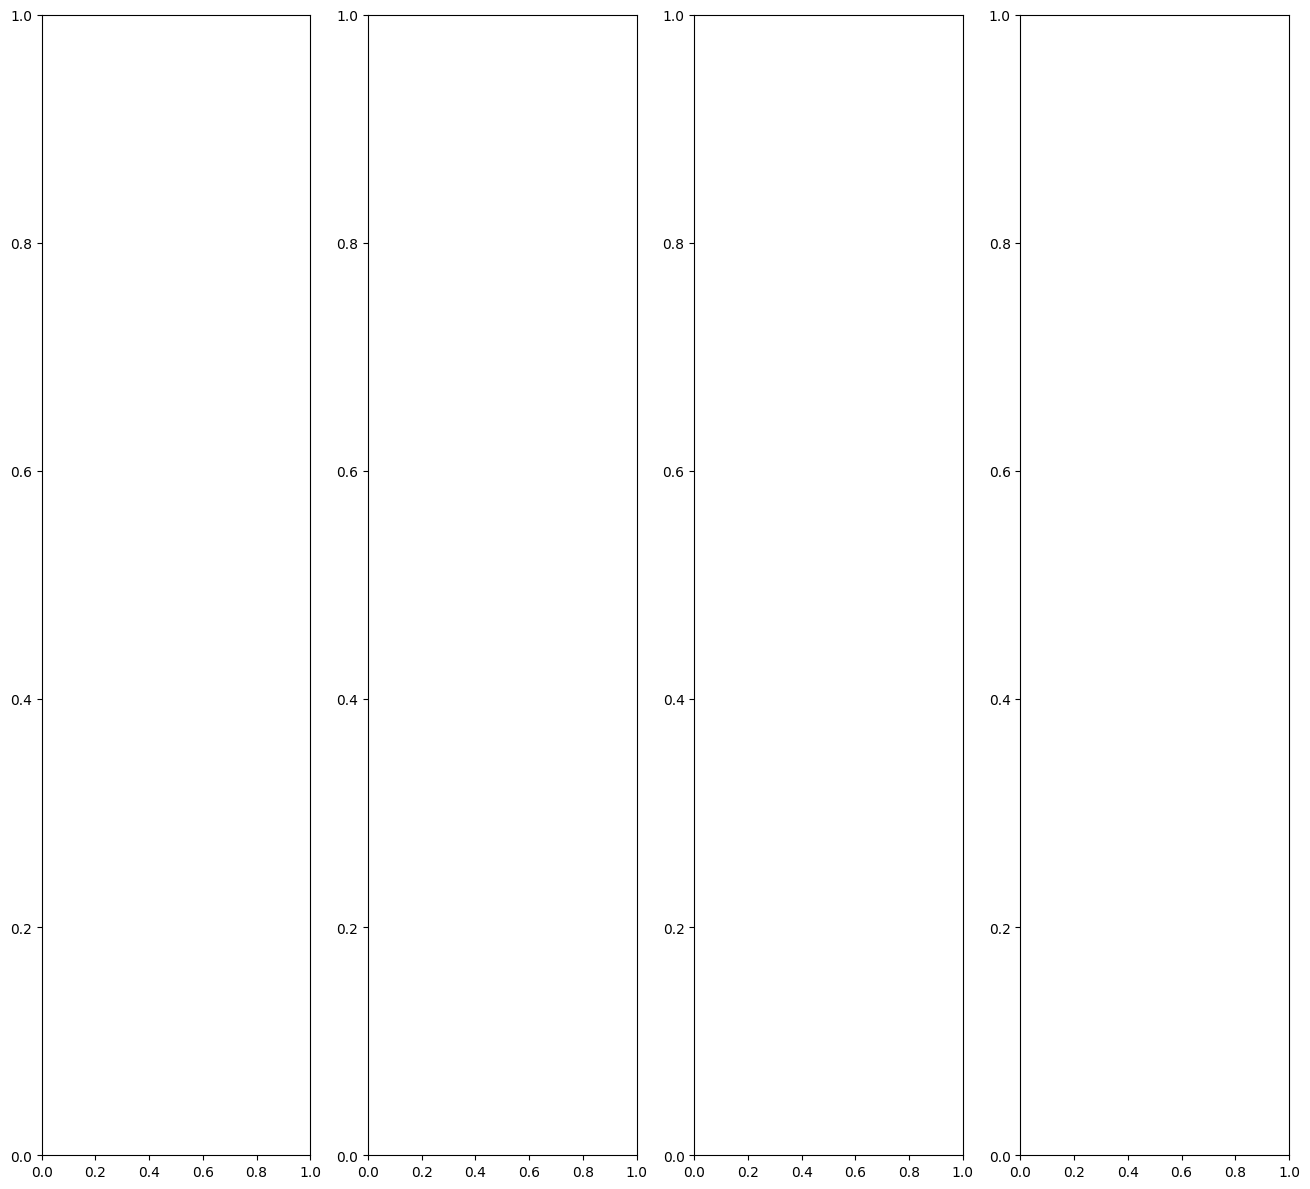

In [27]:
display_samples_h(samples)